# Chest X-Ray Data Exploration


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from collections import Counter

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline

## 1. Dataset Overview

In [2]:
data_dir = '../data/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

if not os.path.exists(data_dir):
    print("❌ Data directory not found!")
else:
    print("✓ Data directory found")

✓ Data directory found


In [3]:
def count_images(directory):
    """Count images in each class"""
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("Dataset Distribution:")
print(f"\nTrain: {train_counts}")
print(f"Total: {sum(train_counts.values())}")
print(f"\nValidation: {val_counts}")
print(f"Total: {sum(val_counts.values())}")
print(f"\nTest: {test_counts}")
print(f"Total: {sum(test_counts.values())}")

Dataset Distribution:

Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Total: 5216

Validation: {'NORMAL': 8, 'PNEUMONIA': 8}
Total: 16

Test: {'NORMAL': 234, 'PNEUMONIA': 390}
Total: 624


## 2. Class Distribution Visualization

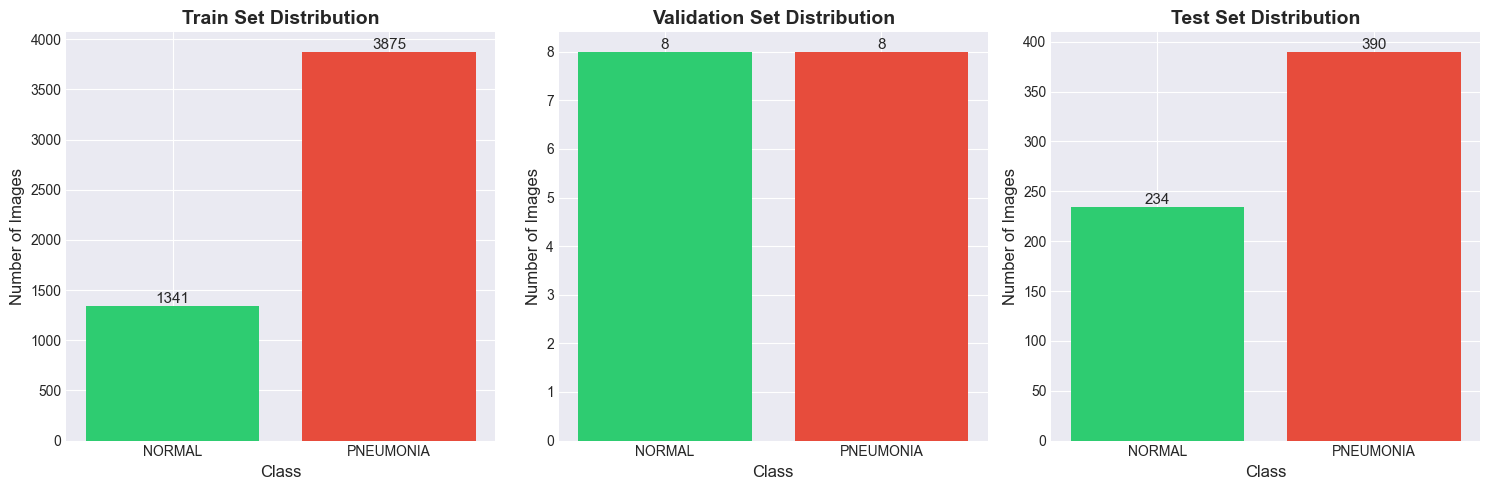

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [('Train', train_counts), ('Validation', val_counts), ('Test', test_counts)]

for ax, (title, counts) in zip(axes, datasets):
    classes = list(counts.keys())
    values = list(counts.values())
    
    bars = ax.bar(classes, values, color=['#2ecc71', '#e74c3c'])
    ax.set_title(f'{title} Set Distribution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12)
    ax.set_xlabel('Class', fontsize=12)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

In [5]:
print("Class Imbalance Analysis:")
for name, counts in datasets:
    if len(counts) == 2:
        ratio = max(counts.values()) / min(counts.values())
        print(f"{name}: {ratio:.2f}:1")

Class Imbalance Analysis:
Train: 2.89:1
Validation: 1.00:1
Test: 1.67:1


## 3. Sample Images

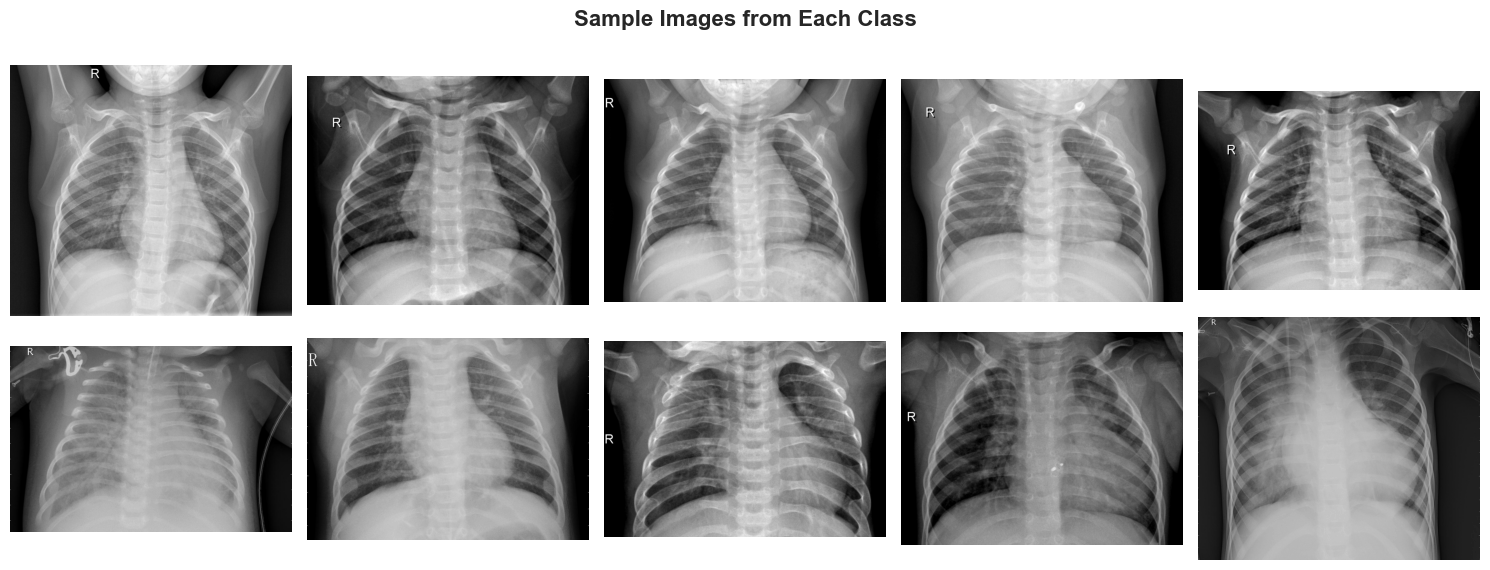

In [6]:
def show_samples(directory, n_samples=5):
    """Show sample images from each class"""
    classes = sorted(os.listdir(directory))
    
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 6))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)[:n_samples]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_ylabel(class_name.upper(), 
                                     fontsize=12, fontweight='bold')
    
    plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_samples(train_dir, n_samples=5)

## 4. Image Size Analysis

In [7]:
def analyze_image_sizes(directory, n_samples=100):
    """Analyze image dimensions"""
    widths = []
    heights = []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
            
        images = os.listdir(class_path)[:n_samples]
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                w, h = img.size
                widths.append(w)
                heights.append(h)
            except:
                continue
    
    return widths, heights

widths, heights = analyze_image_sizes(train_dir, n_samples=200)

print("Image Size Statistics:")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Avg: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Avg: {np.mean(heights):.1f}")

Image Size Statistics:
Width  - Min: 502, Max: 2538, Avg: 1442.4
Height - Min: 307, Max: 2066, Avg: 1086.1


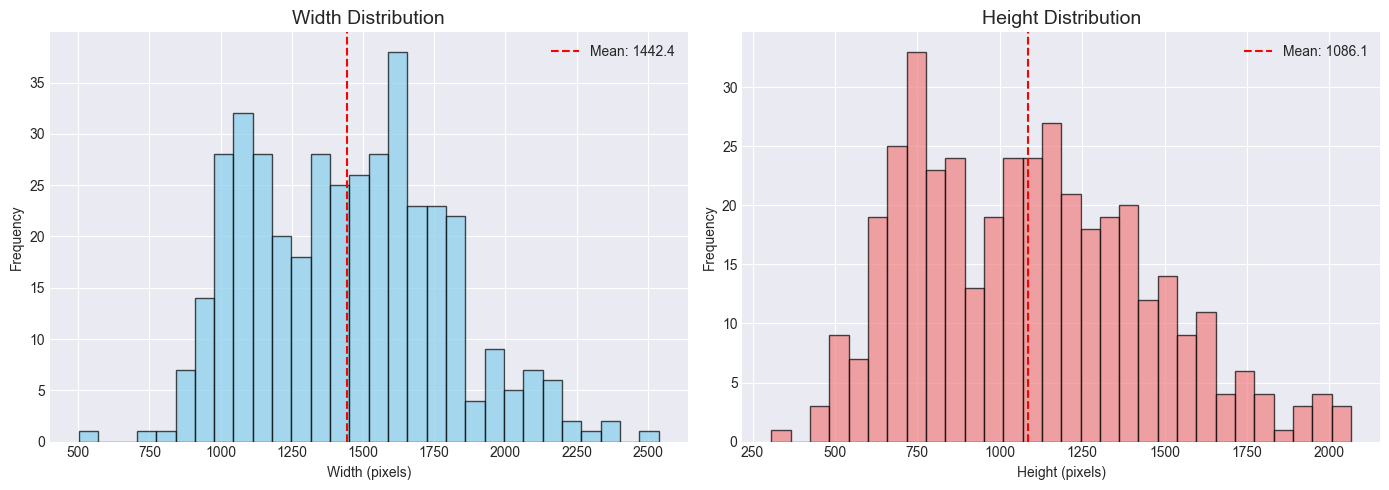

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Width Distribution', fontsize=14)
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.1f}')
axes[0].legend()

axes[1].hist(heights, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_title('Height Distribution', fontsize=14)
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Pixel Intensity Analysis

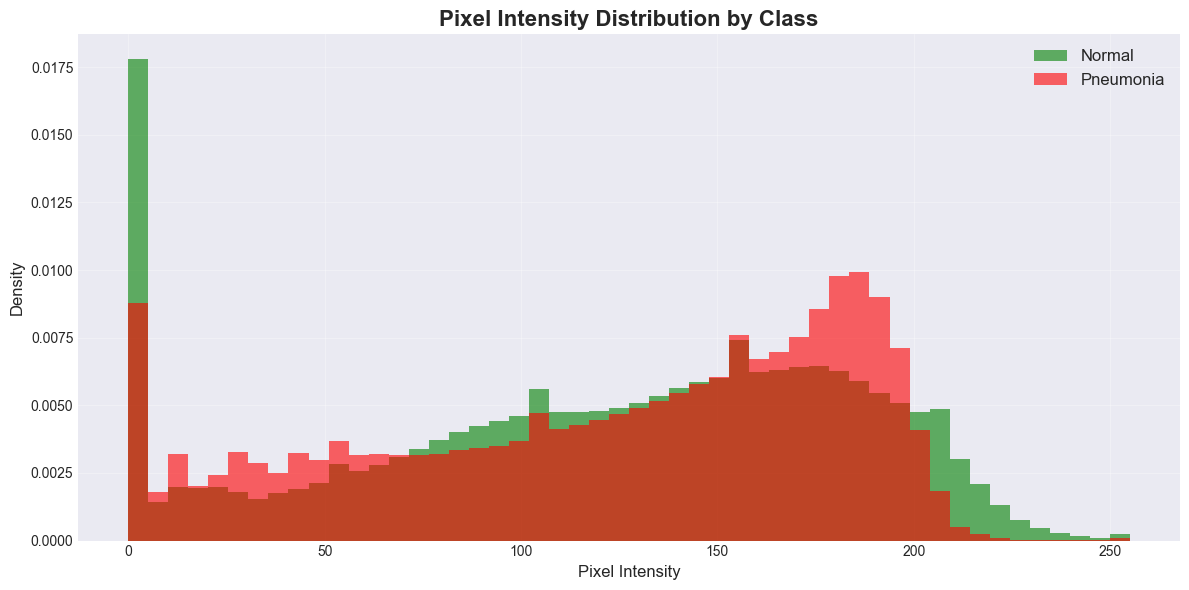

Normal - Mean: 120.16, Std: 64.10
Pneumonia - Mean: 122.52, Std: 60.17


In [9]:
def analyze_pixel_intensity(directory, class_name, n_samples=10):
    """Analyze pixel intensity distribution"""
    class_path = os.path.join(directory, class_name)
    images = os.listdir(class_path)[:n_samples]
    
    all_pixels = []
    
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = np.array(Image.open(img_path))
        all_pixels.extend(img.flatten())
    
    return all_pixels

# Get pixel values for each class
normal_pixels = analyze_pixel_intensity(train_dir, 'NORMAL', n_samples=20)
pneumonia_pixels = analyze_pixel_intensity(train_dir, 'PNEUMONIA', n_samples=20)

# Plot distributions
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(normal_pixels, bins=50, alpha=0.6, label='Normal', color='green', density=True)
ax.hist(pneumonia_pixels, bins=50, alpha=0.6, label='Pneumonia', color='red', density=True)

ax.set_title('Pixel Intensity Distribution by Class', fontsize=16, fontweight='bold')
ax.set_xlabel('Pixel Intensity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Normal - Mean: {np.mean(normal_pixels):.2f}, Std: {np.std(normal_pixels):.2f}")
print(f"Pneumonia - Mean: {np.mean(pneumonia_pixels):.2f}, Std: {np.std(pneumonia_pixels):.2f}")

## 6. Summary and Insights

Key observations:
1. **Class Imbalance**: The dataset is imbalanced with more pneumonia cases than normal
2. **Image Sizes**: Images vary in size and will need to be resized for model input
3. **Pixel Intensities**: Normal and pneumonia X-rays show different intensity patterns
4. **Data Augmentation**: Given the imbalance, data augmentation will be crucial
5. **Class Weights**: Should use class weights during training to handle imbalance

In [10]:
summary = {
    'Total Training Images': sum(train_counts.values()),
    'Total Validation Images': sum(val_counts.values()),
    'Total Test Images': sum(test_counts.values()),
    'Class Ratio (Train)': f"{train_counts.get('PNEUMONIA', 0) / train_counts.get('NORMAL', 1):.2f}:1",
    'Recommended Image Size': '224x224 (standard for transfer learning)',
    'Recommended Batch Size': '32 (adjust based on GPU memory)',
    'Use Class Weights': 'Yes (due to imbalance)',
    'Use Data Augmentation': 'Yes (rotation, shift, flip)'
}

print("\n" + "="*60)
print("DATASET SUMMARY & RECOMMENDATIONS")
print("="*60)
for key, value in summary.items():
    print(f"{key:.<40} {value}")
print("="*60)


DATASET SUMMARY & RECOMMENDATIONS
Total Training Images................... 5216
Total Validation Images................. 16
Total Test Images....................... 624
Class Ratio (Train)..................... 2.89:1
Recommended Image Size.................. 224x224 (standard for transfer learning)
Recommended Batch Size.................. 32 (adjust based on GPU memory)
Use Class Weights....................... Yes (due to imbalance)
Use Data Augmentation................... Yes (rotation, shift, flip)
